# MNIST 숫자 분류를 위한 Stacked AutoEncoder + Softmax Classifier

<img src="http://deeplearning.stanford.edu/wiki/images/5/5c/Stacked_Combined.png" width="600">
### 위 그림에서 볼 수 있듯이 2번째 hidden layer에서 추출한 압축된 Featrues(784->200)를 Softmax Classifer에 Raw Input(784)대신에 사용한다.
### 그 결과 정확도가 약 92%에서 97%로 향상되었다.

# 라이브러리 임포트 및 MNIST 데이터 다운로드

In [23]:
# 절대 임포트 설정
from __future__ import division, print_function, absolute_import

# 필요한 라이브러리들을 임포트
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터를 다운로드 한다.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# 파라미터 설정

In [3]:
# 파라미터 설정
learning_rate_RMSProp = 0.01
learning_rate_Gradient_Descent = 0.5
training_epochs = 400     # epoch 횟수 (iteration)
softmax_classifier_iterations = 1000 # Softmax Classifier iteration 횟수 
batch_size = 256          
display_step = 1        # 몇 Step마다 log를 출력할지 결정한다.
examples_to_show = 10   # reconstruct된 이미지 중 몇개를 보여줄지를 결정한다. 
n_hidden_1 = 200        # 첫번째 히든레이어의 노드 개수 
n_hidden_2 = 200        # 두번째 히든레이어의 노드 개수 
n_input = 784           # MNIST 데이터 input (이미지 크기: 28*28)

# Stacked Autoencoder & Softmax Classifier 구현

In [5]:
# Stacked Autoencoder를 생성한다.
def build_autoencoder():
    # 히든 레이어 1을 위한 Weights와 Biases
    Wh_1 = tf.Variable(tf.random_normal([n_input, n_hidden_1]))   
    bh_1 = tf.Variable(tf.random_normal([n_hidden_1]))
    h_1 = tf.nn.sigmoid(tf.matmul(X, Wh_1) +bh_1)     # 히든레이어 1의 activation (sigmoid 함수를 사용)
    # 히든 레이어 2을 위한 Weights와 Biases
    Wh_2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]))
    bh_2 = tf.Variable(tf.random_normal([n_hidden_2]))
    h_2 = tf.nn.sigmoid(tf.matmul(h_1, Wh_2) +bh_2)   # 히든레이어 2의 activation (sigmoid 함수를 사용)
    # Output 레이어를 위한 Weights와 Biases
    Wo = tf.Variable(tf.random_normal([n_hidden_2, n_input]))
    bo = tf.Variable(tf.random_normal([n_input]))
    X_reconstructed = tf.nn.sigmoid(tf.matmul(h_2,Wo) + bo)   # Output 레이어의 activation (sigmoid 함수를 사용)
    return X_reconstructed, h_2 

# Softmax Classifier를 생성한다.
def build_softmax_classifier():
    # Softmax Classifier를 위한 파라미터들
    W = tf.Variable(tf.zeros([n_hidden_2, 10]))
    b = tf.Variable(tf.zeros([10]))
    y_pred = tf.nn.softmax(tf.matmul(extracted_features, W) + b)      # 예측된 Output : 두번째 히든레이어의 activation output을 input으로 사용한다. 
    return y_pred

# 학습에 필요한 변수들 설정

In [6]:
X = tf.placeholder("float", [None, n_input])    # Input 데이터 설정
y_pred, extracted_features = build_autoencoder() # Autoencoder의 Reconstruction 결과, 압축된 Features(h_2=200)
y_true = X # Output 값(True Output)을 설정(=Input 값)
y = build_softmax_classifier()                # Predicted Output using Softmax Classifier
y_ = tf.placeholder(tf.float32, [None, 10])   # True Output

# Cost Function 및 Optimizer 정의

In [8]:
# Optimization을 위한 파라미터들
# Autoencoder Optimization을 위한 파라미터들 
reconsturction_cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))     # squared error loss 함수
initial_optimizer = tf.train.RMSPropOptimizer(learning_rate_RMSProp).minimize(reconsturction_cost)

# Softmax Classifier Optimization을 위한 파라미터들 
cross_entropy_cost = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))     # cross-entropy loss 함수
softmax_classifier_optimizer = tf.train.GradientDescentOptimizer(learning_rate_Gradient_Descent).minimize(cross_entropy_cost)

# Fine Tuning Optimization을 위한 파라미터들
finetuning_cost = cross_entropy_cost + reconsturction_cost
finetuning_optimizer = tf.train.GradientDescentOptimizer(learning_rate_Gradient_Descent).minimize(finetuning_cost)


In [11]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


# Step 1: Stacked Autoencoder를 pre-training 한다.

In [12]:
# Step 1: Stacked Autoencoder pre-training 
total_batch = int(mnist.train.num_examples/batch_size)
# Training을 시작한다.
for epoch in range(training_epochs):
    # 모든 배치들을 돌아가면서(Loop) 학습한다.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # batch 데이터를 이용해서 트레이닝을 진행한다.
        _, cost_value = sess.run([initial_optimizer, reconsturction_cost], feed_dict={X: batch_xs})
    # 일정 epoch step마다 로그를 출력한다.
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(cost_value))
print("Stacked Autoencoder pre-training Optimization Finished!")

Epoch: 0001 cost= 0.158525854
Epoch: 0002 cost= 0.133226812
Epoch: 0003 cost= 0.121579468
Epoch: 0004 cost= 0.113997906
Epoch: 0005 cost= 0.109741934
Epoch: 0006 cost= 0.107572578
Epoch: 0007 cost= 0.105392426
Epoch: 0008 cost= 0.100794502
Epoch: 0009 cost= 0.101420149
Epoch: 0010 cost= 0.098634169
Epoch: 0011 cost= 0.096071504
Epoch: 0012 cost= 0.094528235
Epoch: 0013 cost= 0.097615585
Epoch: 0014 cost= 0.093509555
Epoch: 0015 cost= 0.090802796
Epoch: 0016 cost= 0.089569956
Epoch: 0017 cost= 0.091071218
Epoch: 0018 cost= 0.089095317
Epoch: 0019 cost= 0.090093322
Epoch: 0020 cost= 0.090267085
Epoch: 0021 cost= 0.089687638
Epoch: 0022 cost= 0.086409546
Epoch: 0023 cost= 0.087544069
Epoch: 0024 cost= 0.085111022
Epoch: 0025 cost= 0.085230060
Epoch: 0026 cost= 0.084057651
Epoch: 0027 cost= 0.083243795
Epoch: 0028 cost= 0.082743138
Epoch: 0029 cost= 0.083979391
Epoch: 0030 cost= 0.083366118
Epoch: 0031 cost= 0.082303226
Epoch: 0032 cost= 0.083305970
Epoch: 0033 cost= 0.080362812
Epoch: 003

Epoch: 0275 cost= 0.046297599
Epoch: 0276 cost= 0.047154076
Epoch: 0277 cost= 0.045017682
Epoch: 0278 cost= 0.047336914
Epoch: 0279 cost= 0.047152616
Epoch: 0280 cost= 0.044914372
Epoch: 0281 cost= 0.045272145
Epoch: 0282 cost= 0.045212526
Epoch: 0283 cost= 0.046746839
Epoch: 0284 cost= 0.046243496
Epoch: 0285 cost= 0.044750363
Epoch: 0286 cost= 0.045765001
Epoch: 0287 cost= 0.047253542
Epoch: 0288 cost= 0.044625647
Epoch: 0289 cost= 0.045659211
Epoch: 0290 cost= 0.044146013
Epoch: 0291 cost= 0.046160556
Epoch: 0292 cost= 0.045351192
Epoch: 0293 cost= 0.045025799
Epoch: 0294 cost= 0.046561226
Epoch: 0295 cost= 0.045209475
Epoch: 0296 cost= 0.044737779
Epoch: 0297 cost= 0.043962527
Epoch: 0298 cost= 0.046161253
Epoch: 0299 cost= 0.043905050
Epoch: 0300 cost= 0.043581929
Epoch: 0301 cost= 0.045484528
Epoch: 0302 cost= 0.045184340
Epoch: 0303 cost= 0.043801520
Epoch: 0304 cost= 0.045244087
Epoch: 0305 cost= 0.044788294
Epoch: 0306 cost= 0.043427788
Epoch: 0307 cost= 0.043686062
Epoch: 030

# Step 2: test 데이터셋을 autoencoder로 reconstruction 해본다.

Populating the interactive namespace from numpy and matplotlib


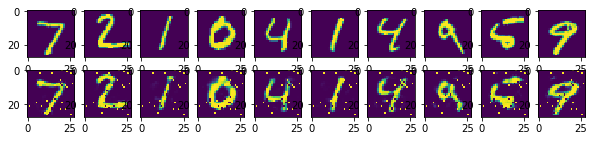

In [25]:
# Step 2: test 데이터셋을 autoencoder로 reconstruction 해본다.
%pylab inline

reconstructed_image = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
# 원본 이미지와 재구축(reconstructed)된 이미지를 비교한다.
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(reconstructed_image[i], (28, 28)))
f.show()
plt.draw()

# Step 3: Softmax Classifier를 학습한다.

In [26]:
# Step 3: Softmax Classifier를 학습한다.
for i in range(softmax_classifier_iterations):
  batch_xs, batch_ys = mnist.train.next_batch(100)     
  sess.run(softmax_classifier_optimizer, feed_dict={X: batch_xs, y_: batch_ys})  
print("Softmax Classifier Optimization Finished!")

Softmax Classifier Optimization Finished!


# Step 4: 학습된 모델이 얼마나 정확한지를 출력한다. (Before fine-tuning) 

In [28]:
# Step 4: 학습된 모델이 얼마나 정확한지를 출력한다. (Before fine-tuning) 
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy(before fine-tuning): ")   # Accuracy ~ 0.9282
print(sess.run(accuracy, feed_dict={X: mnist.test.images, y_: mnist.test.labels}))

Accuracy(before fine-tuning): 
0.9259


# Step 5: Stacked Autoencoder + Softmax Classifer를 Fine-tuning한다.

In [29]:
# Step 5: Fine-tuning softmax model
# Training을 시작한다.
for epoch in range(training_epochs):
   # 모든 배치들을 돌아가면서(Loop) 학습한다.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # batch 데이터를 이용해서 트레이닝을 진행한다.
        _, cost_value = sess.run([finetuning_optimizer, finetuning_cost], feed_dict={X: batch_xs,  y_: batch_ys})
    # 일정 epoch step마다 로그를 출력한다.
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(cost_value))
print("Fine-tuning softmax model Optimization Finished!")

Epoch: 0001 cost= 0.263495713
Epoch: 0002 cost= 0.272298932
Epoch: 0003 cost= 0.257943630
Epoch: 0004 cost= 0.233027980
Epoch: 0005 cost= 0.222692251
Epoch: 0006 cost= 0.237469345
Epoch: 0007 cost= 0.157491475
Epoch: 0008 cost= 0.192647204
Epoch: 0009 cost= 0.159885630
Epoch: 0010 cost= 0.176787183
Epoch: 0011 cost= 0.191338837
Epoch: 0012 cost= 0.189123809
Epoch: 0013 cost= 0.113121688
Epoch: 0014 cost= 0.123413429
Epoch: 0015 cost= 0.136362717
Epoch: 0016 cost= 0.237484783
Epoch: 0017 cost= 0.120154925
Epoch: 0018 cost= 0.117479071
Epoch: 0019 cost= 0.124656163
Epoch: 0020 cost= 0.141643152
Epoch: 0021 cost= 0.143698260
Epoch: 0022 cost= 0.134220451
Epoch: 0023 cost= 0.136470795
Epoch: 0024 cost= 0.085744970
Epoch: 0025 cost= 0.155369550
Epoch: 0026 cost= 0.112848446
Epoch: 0027 cost= 0.112621643
Epoch: 0028 cost= 0.121596560
Epoch: 0029 cost= 0.095881574
Epoch: 0030 cost= 0.114285827
Epoch: 0031 cost= 0.079277694
Epoch: 0032 cost= 0.124700755
Epoch: 0033 cost= 0.085371867
Epoch: 003

Epoch: 0275 cost= 0.046752956
Epoch: 0276 cost= 0.046331916
Epoch: 0277 cost= 0.048798990
Epoch: 0278 cost= 0.045777574
Epoch: 0279 cost= 0.046754431
Epoch: 0280 cost= 0.045602921
Epoch: 0281 cost= 0.045668457
Epoch: 0282 cost= 0.046416920
Epoch: 0283 cost= 0.044877023
Epoch: 0284 cost= 0.045549113
Epoch: 0285 cost= 0.046014033
Epoch: 0286 cost= 0.047755580
Epoch: 0287 cost= 0.044417743
Epoch: 0288 cost= 0.044561293
Epoch: 0289 cost= 0.047412910
Epoch: 0290 cost= 0.045973558
Epoch: 0291 cost= 0.046257503
Epoch: 0292 cost= 0.045023397
Epoch: 0293 cost= 0.046453465
Epoch: 0294 cost= 0.045052558
Epoch: 0295 cost= 0.045158535
Epoch: 0296 cost= 0.045873802
Epoch: 0297 cost= 0.045898322
Epoch: 0298 cost= 0.045503180
Epoch: 0299 cost= 0.047665279
Epoch: 0300 cost= 0.044480316
Epoch: 0301 cost= 0.046929654
Epoch: 0302 cost= 0.044396766
Epoch: 0303 cost= 0.046642717
Epoch: 0304 cost= 0.046322480
Epoch: 0305 cost= 0.046275720
Epoch: 0306 cost= 0.044685762
Epoch: 0307 cost= 0.045302462
Epoch: 030

# Step 6: 학습된 모델이 얼마나 정확한지를 출력한다. (After fine-tuning)

In [30]:
print("Accuracy(after fine-tuning): ")      # Accuracy ~ 0.9714
print(sess.run(accuracy, feed_dict={X: mnist.test.images, y_: mnist.test.labels}))

Accuracy(after fine-tuning): 
0.97
